In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [3]:
PATH_2210 = "Datos\E01_T_DEU_CONS_2210_REV.csv"
PATH_2211 = "Datos\E01_T_DEU_CONS_2211_REV.csv"
PATH_2212 = "Datos\E01_T_DEU_CONS_2212_REV.csv"
PATH_2301 = "Datos\E01_T_DEU_CONS_2301_REV.csv"
PATH_2302 = "Datos\E01_T_DEU_CONS_2302_REV.csv"
PATH_2303 = "Datos\E01_T_DEU_CONS_2303_REV.csv"
PATH_DICC = "Datos\Diccionario T_DEU_CONS.xlsx"
BANCO_CODS = [39,27]
MONEDA_CODS = [1,2,3] # Peso chileno, UF y dolar

In [4]:
df2210 = pd.read_csv(PATH_2210, delimiter=";")
#df2211 = pd.read_csv(PATH_2211,delimiter=";")

In [4]:
def get_nan_cols(df, nan_percent=0.8):
    'Retorna columnas con porcentaje NaN mayor a nan_percent'
    threshold = len(df.index) * nan_percent
    return [c for c in df.columns if sum(df[c].isnull()) >= threshold]  

In [8]:
df2210 = df2210[['CODFAM', 'CODPRO',
       'CODTLP', 'CODCLAS', 'ESTADO', 'MTOINT', 'MTOORIG', 'MTOORIGP',
       'MONEDA', 'MTOVENC', 'DCOMO2', 'DCOMO3', 'MTOCAST', 'DIASMORA',
       'MTOREV',  'TASAINT', 'FECOPE',
       'FECVEN', 'SALDOPUNTA','MCUOTA', 'SPROM']].dropna()
df2210.shape

(866145, 21)

In [9]:
# Por ahora solo con numericos
df_num = df2210[['ESTADO', 'MTOINT', 'MTOORIG', 'MTOORIGP',
       'MONEDA', 'MTOVENC', 'DCOMO2', 'DCOMO3', 'MTOCAST', 'DIASMORA',
       'MTOREV',  'TASAINT', 'FECOPE',
       'FECVEN', 'SALDOPUNTA','MCUOTA', 'SPROM']]

# df_num.hist(bins = 20, figsize =(20, 10))
# plt.show()

<ipython-input-38-a547bcdd2756>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num["iForest_outliers"] = predictions
<ipython-input-38-a547bcdd2756>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num["iForest_scores"] = iForest.decision_function(df_num[['MTOINT', 'MTOREV']].values)


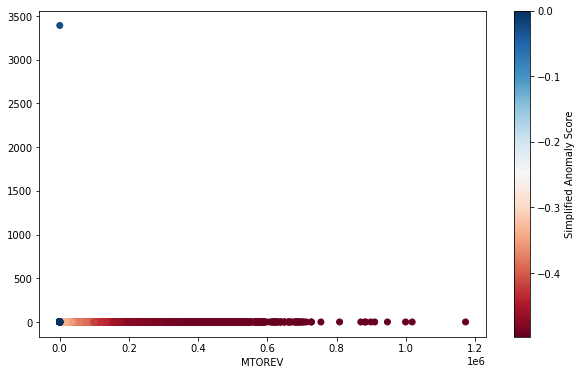

In [38]:
iForest = IsolationForest(n_estimators=100, verbose=0, contamination=0.05)
iForest.fit(df_num[['MTOINT', 'MTOREV']].values)
predictions = iForest.predict(df_num[['MTOINT', 'MTOREV']].values)

# Extract predictions
df_num["iForest_outliers"] = predictions
# Extract Scores
df_num["iForest_scores"] = iForest.decision_function(df_num[['MTOINT', 'MTOREV']].values)

fig, ax = plt.subplots(1,1, figsize=(10,6))
plt.scatter(df_num.MTOINT, df_num.MTOREV, c=df_num.iForest_scores, cmap='RdBu')
plt.xlabel('MTOINT')
plt.xlabel('MTOREV')
plt.colorbar(label='Simplified Anomaly Score')
plt.show()

In [63]:
def test_2_var(var1, var2, cont):
    iForest = IsolationForest(n_estimators=20, verbose=0, contamination=cont)
    iForest.fit(df_num[[var1, var2]].values)
    predictions = iForest.predict(df_num[[var1, var2]].values)

    # Extract predictions
    #df_num["iForest_outliers"] = predictions
    # Extract Scores
    df_num["iForest_scores"] = -1*iForest.score_samples(df_num[[var1, var2]].values)

    fig, ax = plt.subplots(1,1, figsize=(10,6))
    plt.scatter(df_num[var1], df_num[var2], c=df_num.iForest_scores, cmap='RdBu')
    plt.xlabel(var1)
    plt.ylabel(var2)
    plt.colorbar(label='Simplified Anomaly Score')
    plt.show()

    fig, ax = plt.subplots(1,1, figsize=(10,6))
    plt.hist(df_num.iForest_scores, bins=20)
    plt.title('Probabilidad de outliers')
    #plt.xticks([-1, 1])
    plt.show()

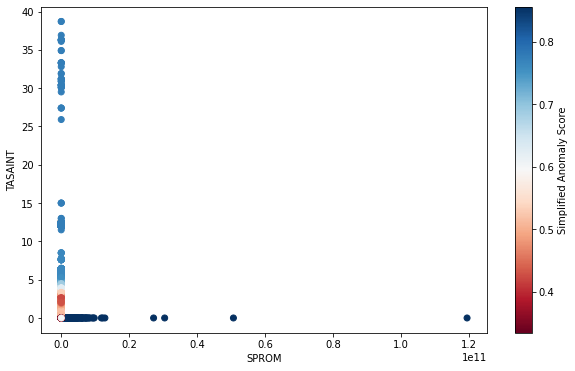

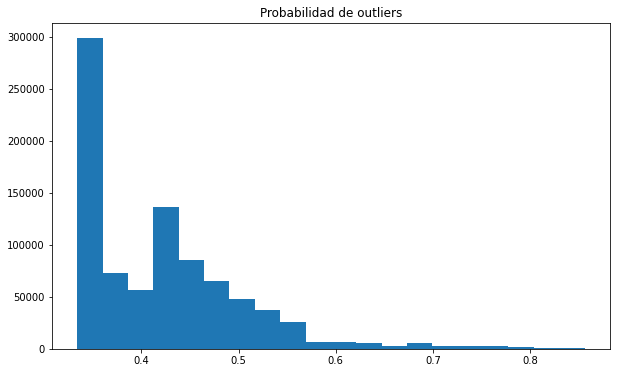

In [64]:
test_2_var('SPROM', 'TASAINT', cont=0.5)

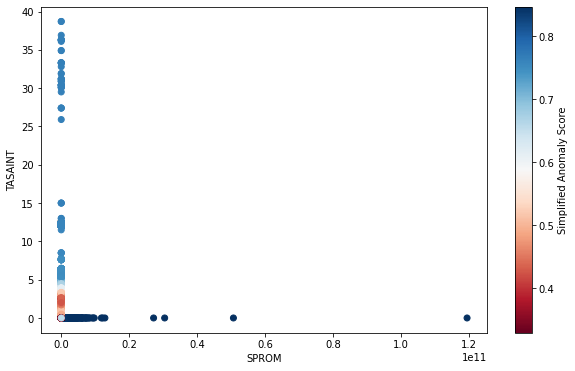

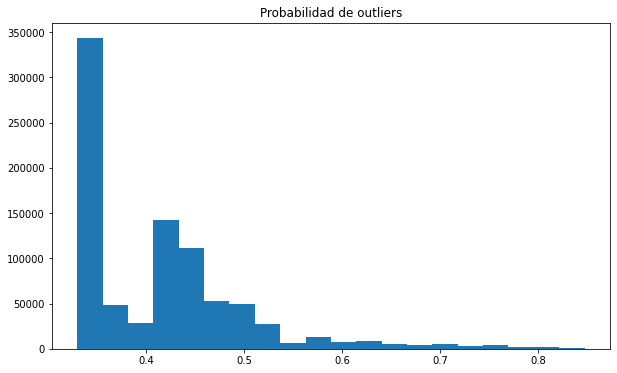

In [62]:
test_2_var('SPROM', 'TASAINT')

<ipython-input-51-7ae820b2781b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num["iForest_scores"] = -1*iForest.score_samples(df_num[[var1, var2]].values)


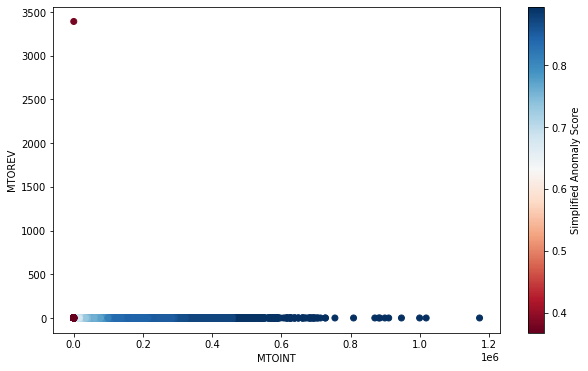

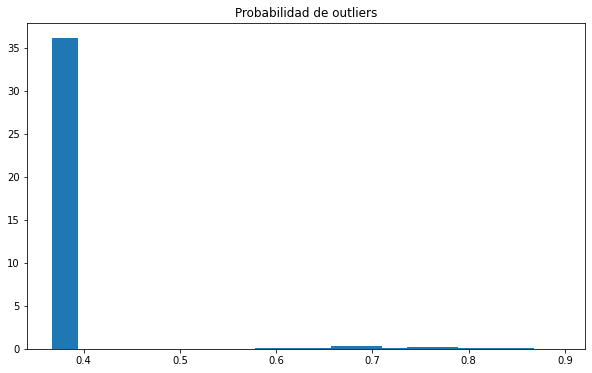

In [52]:
test_2_var('MTOINT', 'MTOREV')

# Con PCA (para visualizacion)

Aplicaremos PCA para reducir la dimensionalidad (esto es solo con fines de visualizacion)

Tomamos muestra de variables a analizar, y vemos si necesitamos 2 o 3 PCs para reducir dim

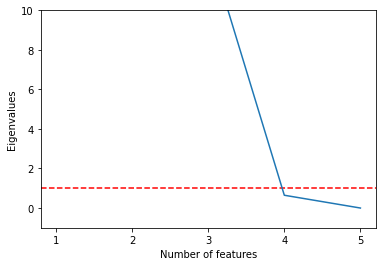

In [216]:
dfelbow = df2210[['MTOINT', 'DIASMORA', 'MTOREV', 'TASAINT', 'MCUOTA']]

covar_matrix = PCA(n_components=len(dfelbow.columns))
covar_matrix.fit(dfelbow)

Xelbow = [i for i in range(1, len(dfelbow.columns) + 1 )]

plt.ylabel('Eigenvalues')
plt.xlabel('Number of features')
plt.xticks(Xelbow)
plt.ylim(-1, 10)
plt.axhline(y=1, color='r', linestyle='--')
plt.plot(Xelbow, covar_matrix.explained_variance_)
plt.show()

In [85]:
def iso_forest2(df, n_components, n_estimators, contamination):
    'Primero hacemos iForest, luego PCA'

    if 'is_anomaly_prediction' in df.columns:
        df.drop(columns=['is_anomaly_prediction'], axis=1, inplace=True)
    if 'iForest_scores' in df.columns:
        df.drop(columns=['iForest_scores', 'iForest_outliers'], axis=1, inplace=True)

    # iForest
    # Hay que hacer cross validation de CONTAMINATION
    iForest = IsolationForest(n_estimators=n_estimators, verbose=0, contamination=contamination)
    iForest.fit(df.values)
    predictions = iForest.predict(df.values)

    # Extract scores
    df["iForest_scores"] = -1*iForest.score_samples(df.values)
    # Extract predictions
    df["iForest_outliers"] = predictions
    # Describe the dataframe
    print('Summary')
    print(df[['iForest_scores', 'iForest_outliers']].describe())

    # Standardize features
    df_scaled = StandardScaler().fit_transform(df)
    # Define dimensions = 2
    pca = PCA(n_components=n_components)
    # Conduct the PCA
    principal_comp = pca.fit_transform(df_scaled)
    # Convert to dataframe

    pca_df = pd.DataFrame(data = principal_comp, columns = [f'PC{i+1}' for i in range(n_components)])

    print('Prediciones:', df.iForest_outliers.value_counts())

    if n_components == 2:
        fig, ax = plt.subplots(1,1, figsize=(10,8))
        plt.scatter(pca_df.PC1, pca_df.PC2, c=df.iForest_scores, cmap='RdBu')
        plt.title(f'iForest scores, $\lambda = {contamination}$')
        plt.colorbar(label='iForest outliers')
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        plt.show()
    elif n_components == 3:
        fig = plt.figure(figsize=(10,8))
        ax = fig.add_subplot(projection='3d')
        ax.scatter(pca_df.PC1, pca_df.PC2, pca_df.PC3, c=df.iForest_scores, cmap='RdBu')
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')
    else:
        print('No es posible visualizar resultados para mas componentes')

    #return df.iForest_outliers, df.iForest_scores

Summary
       iForest_scores  iForest_outliers
count   866145.000000     866145.000000
mean         0.408115          0.800017
std          0.079318          0.599977
min          0.329506         -1.000000
25%          0.343231          1.000000
50%          0.386885          1.000000
75%          0.444384          1.000000
max          0.748309          1.000000
Prediciones: iForest_outliers
 1    779538
-1     86607
Name: count, dtype: int64


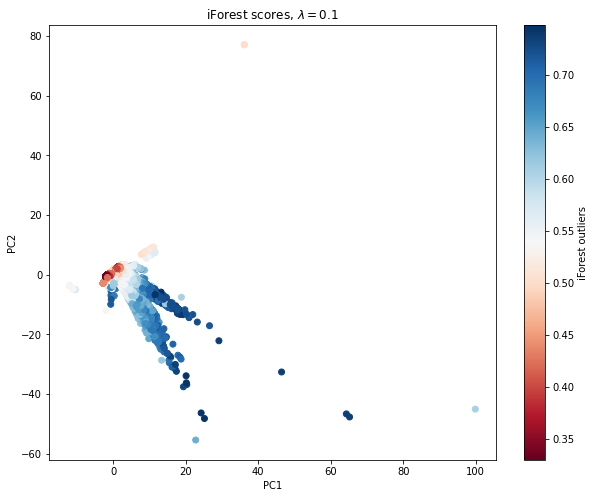

In [86]:
iso_forest2(df_num, 2, 20, 0.1)

# Mass-Volume y Excess-Mass

In [30]:
import warnings
warnings.filterwarnings('ignore')

# Extraido de https://github.com/ngoix/EMMV_benchmarkss

import numpy as np
from sklearn.metrics import auc


def em(t, t_max, volume_support, s_unif, s_X, n_generated):
    EM_t = np.zeros(t.shape[0])
    n_samples = s_X.shape[0]
    s_X_unique = np.unique(s_X)
    EM_t[0] = 1.
    for u in s_X_unique:
        # if (s_unif >= u).sum() > n_generated / 1000:
        EM_t = np.maximum(EM_t, 1. / n_samples * (s_X > u).sum() -
                          t * (s_unif > u).sum() / n_generated
                          * volume_support)
    amax = np.argmax(EM_t <= t_max) + 1
    if amax == 1:
        print('\n failed to achieve t_max \n')
        amax = -1
    AUC = auc(t[:amax], EM_t[:amax])
    return AUC, EM_t, amax


def mv(axis_alpha, volume_support, s_unif, s_X, n_generated):
    n_samples = s_X.shape[0]
    s_X_argsort = s_X.argsort()
    mass = 0
    cpt = 0
    u = s_X[s_X_argsort[-1]]
    mv = np.zeros(axis_alpha.shape[0])
    for i in range(axis_alpha.shape[0]):
        # pdb.set_trace()
        while mass < axis_alpha[i]:
            cpt += 1
            u = s_X[s_X_argsort[-cpt]]
            mass = 1. / n_samples * cpt  # sum(s_X > u)
        mv[i] = float((s_unif >= u).sum()) / n_generated * volume_support
    return auc(axis_alpha, mv), mv

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.utils import shuffle as sh

# framework: outlier or novelty detection
novelty_detection = False

# parameters of the algorithm:
averaging = 20 # 20 #50
max_features = 5
n_generated = 100 # 1000 #100000
alpha_min = 0.9
alpha_max = 0.999
t_max = 0.9

np.random.seed(1)

# loading and vectorization
X = df_num
n_samples, n_features = np.shape(X)
n_samples_train = n_samples // 2
n_samples_test = n_samples - n_samples_train

X_train = X.iloc[:n_samples_train, :]
X_test = X.iloc[n_samples_train:, :]

# define models:
c_list = [0.02, 0.05, 0.1]
iForest = [IsolationForest(n_estimators=50, contamination=c_list[i]) for i in range(len(c_list))]

n_samples, n_features = X_test.shape
em_iforest = np.array([0 for i in range(len(c_list))], dtype=np.int64)
mv_iforest = np.array([0 for i in range(len(c_list))], dtype=np.int64)

em_iforest1, mv_iforest1 = 0, 0
em_iforest2, mv_iforest2 = 0, 0
em_iforest3, mv_iforest3 = 0, 0

nb_exp = 0
while nb_exp < averaging:
    features = sh(np.arange(n_features))[:max_features]
    X_train_ = X_train.iloc[:, features]
    X_ = X_test.iloc[:, features]

    lim_inf = X_.min(axis=0)
    lim_sup = X_.max(axis=0)
    volume_support = (lim_sup - lim_inf).prod()

    if volume_support > 0:
        nb_exp += 1
        #t = np.arange(0, 100 / volume_support, 0.001 / volume_support)
        t = np.arange(0, 100 / volume_support, 0.1 / volume_support)
        axis_alpha = np.arange(alpha_min, alpha_max, 0.001)
        unif = np.random.uniform(lim_inf, lim_sup,
                                    size=(n_generated, max_features))

        for i, iforest in enumerate(iForest):
            iforest.fit(X_train_)

            s_X_iforest = iforest.decision_function(X_)
            s_unif_iforest = iforest.decision_function(unif)

            if i==0:
                em_iforest1 += em(t, t_max, volume_support, s_unif_iforest,
                                    s_X_iforest, n_generated)[0]
                mv_iforest1 += mv(axis_alpha, volume_support, s_unif_iforest,
                                    s_X_iforest, n_generated)[0]
            elif i==1:
                em_iforest2 += em(t, t_max, volume_support, s_unif_iforest,
                                    s_X_iforest, n_generated)[0]
                mv_iforest2 += mv(axis_alpha, volume_support, s_unif_iforest,
                                    s_X_iforest, n_generated)[0]
            elif i==2:
                em_iforest3 += em(t, t_max, volume_support, s_unif_iforest,
                                    s_X_iforest, n_generated)[0]
                mv_iforest3 += mv(axis_alpha, volume_support, s_unif_iforest,
                                    s_X_iforest, n_generated)[0]

em_iforest1 /= averaging
mv_iforest1 /= averaging
em_iforest2 /= averaging
mv_iforest2 /= averaging
em_iforest3 /= averaging
mv_iforest3 /= averaging

In [39]:
print('EM iForest1 (contamination=0.02):', em_iforest1)
print('MV iForest1 (contamination=0.02):', mv_iforest1)

print('EM iForest2 (contamination=0.05):', em_iforest2)
print('MV iForest2 (contamination=0.05):', mv_iforest2)

print('EM iForest3 (contamination=0.1):', em_iforest3)
print('MV iForest3 (contamination=0.1):', mv_iforest3)

EM iForest1 (contamination=0.02): 5.797896926074965e-18
MV iForest1 (contamination=0.02): 1.0879478500207484e+33
EM iForest2 (contamination=0.05): 1.906149673046711e-16
MV iForest2 (contamination=0.05): 7.896613095399618e+32
EM iForest3 (contamination=0.1): 1.9327266865910771e-16
MV iForest3 (contamination=0.1): 4.871769612111108e+32


In [73]:
df_sample = df_num.sample(n=100000, replace=True, random_state=1)

In [74]:
import shap

iForest = IsolationForest(n_estimators=20, contamination=0.1).fit(X.values)

explainer = shap.Explainer(iForest, df_sample)
shap_values = explainer(df_sample)

 99%|===================| 99422/100000 [00:41<00:00]        

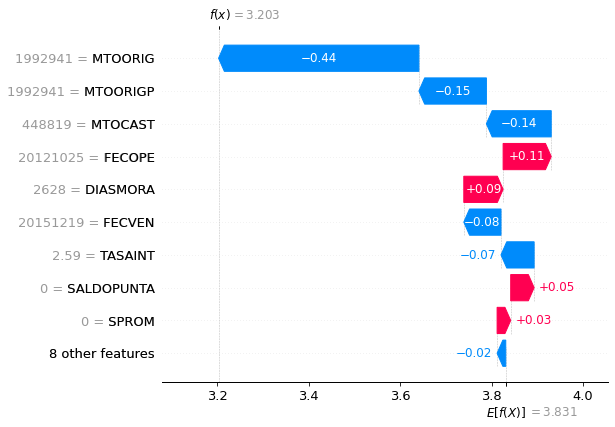

In [75]:
shap.plots.waterfall(shap_values[0])

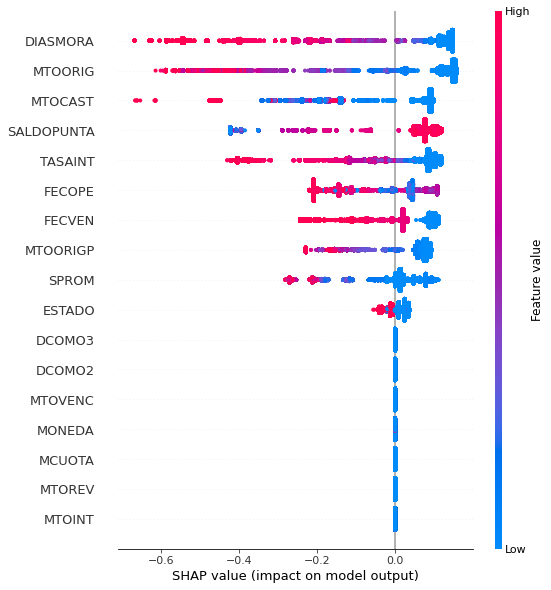

In [77]:
shap_values = shap.TreeExplainer(iForest).shap_values(df_sample)
shap.summary_plot(shap_values, df_sample)

# Categoricas
Para variables categoricas, hacemos OneHotEncoding. Para efectos de nuestros testeos, solo ocupamos variables numericas, pero dejamos los codigos para poder agregar estas variables si el banco lo desea

In [32]:
DICC_CODFAM = list(pd.read_excel(PATH_DICC, sheet_name='CODFAM')['CODIGO'])[1:]
DICC_CODTLP = list(pd.read_excel(PATH_DICC, sheet_name='CODTLP')['CODIGO'])

codfam = pd.get_dummies(df2210.CODFAM, prefix='codfam')
codfam.head()

codpro = pd.get_dummies(df2210.CODPRO, prefix='codpro')
codpro.head()

,codpro_BC01,codpro_BC03,codpro_BC06,codpro_CA
17,False,False,False,True
18,False,False,False,True
19,False,False,False,True
20,False,False,False,True
21,False,False,False,True


In [35]:
df = pd.concat([codfam, codpro], axis=1)
df.head()

,codfam_BCND,codfam_CCTE,codpro_BC01,codpro_BC03,codpro_BC06,codpro_CA
17,False,True,False,False,False,True
18,False,True,False,False,False,True
19,False,True,False,False,False,True
20,False,True,False,False,False,True
21,False,True,False,False,False,True


In [36]:
iForest = IsolationForest(n_estimators=20, verbose=0)
iForest.fit(df)

IsolationForest(n_estimators=20)

In [37]:
pred_scores = -1*iForest.score_samples(df)

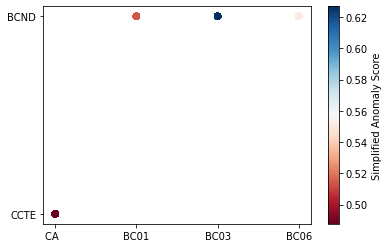

In [40]:
plt.scatter(df2210.CODPRO, df2210.CODFAM, c=pred_scores, cmap='RdBu')
plt.colorbar(label='Simplified Anomaly Score')
plt.show()